In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Dataset parameters
NUM_CLASSES = 10  # MNIST has 10 digit classes
BATCH_SIZE = 512
EPOCHS = 15
LR = 0.001

K_PROBES = 4
EPSILON = 0.1

# Device setup for CUDA
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

class MNISTClassifier(nn.Module):
    def __init__(self, num_classes, k_probes, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.k_probes = k_probes
        self.num_classes = num_classes

        v = torch.randn(k_probes, 2)  # 2D probe directions
        v = v / torch.norm(v, dim=1, keepdim=True)
        self.register_buffer('probes', v)

        # ResNet18 backbone
        resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.intro = nn.Sequential(
            resnet_model.conv1,
            resnet_model.bn1,
            resnet_model.relu,
            resnet_model.maxpool
        )
        self.layer1 = resnet_model.layer1
        self.layer2 = resnet_model.layer2
        self.layer3 = resnet_model.layer3
        self.layer4 = resnet_model.layer4
        self.averagepool = resnet_model.avgpool

        # Classification head (Fixed: 512 + 3 (O0, O1, O2) + 4 (fish layers) = 519)
        self.classifier = nn.Sequential(
            nn.Linear(512 + 3 + 3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        # Compute energy as mean of representation
        energy = x.mean()

        grads = torch.autograd.grad(
            outputs=energy,
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]

        grads_flat = grads.view(grads.size(0), -1)

        # Use only first 2 dimensions or project to 2D space
        if grads_flat.size(1) >= 2:
            grads_2d = grads_flat[:, :2]
        else:
            grads_2d = grads_flat

        scores = -torch.matmul(grads_2d, self.probes.T)
        return scores

    def compute_local_fisher(self, x):
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        # x shape: [batch, 1, 28, 28] for MNIST
        batch_size = x.size(0)

        # Convert 1-channel to 3-channel (RGB) by repeating
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)  # [batch, 3, 28, 28]

        # Resize to ResNet input size (224x224)
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        with torch.set_grad_enabled(True):
            if not x_resized.requires_grad:
                x_resized.requires_grad_(True)

            # Compute derivatives with respect to input
            O0 = self.compute_local_fisher(x_resized)

            # For image tensors, use small Gaussian perturbations instead of probe directions
            perturbation = torch.randn_like(x_resized) * self.epsilon
            x_pos = x_resized + perturbation
            x_neg = x_resized - perturbation

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # Forward through ResNet
        h = self.intro(x_resized)

        # Apply layers and compute Fisher at each stage
        h = self.layer1(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fisher_layer1 = self.compute_local_fisher(h)

        h = self.layer2(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fisher_layer2 = self.compute_local_fisher(h)

        h = self.layer3(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fisher_layer3 = self.compute_local_fisher(h)

        h = self.layer4(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            # fish_layer4 = self.compute_local_fisher(h)

        # Global average pool
        h_pooled = self.averagepool(h)
        h_flat = h_pooled.view(batch_size, -1)  # [batch, 512]

        # Concatenate all features (skip conv_layer processing for now)
        fisher_concat = torch.cat([fisher_layer1, fisher_layer2, fisher_layer3], dim = 1)  ###, fish_layer4], dim=1)
        features = torch.cat([h_flat, O0, O1, O2, fisher_concat], dim=1)

        # Classify
        logits = self.classifier(features)
        return logits

# Create model
model = MNISTClassifier(NUM_CLASSES, K_PROBES, EPSILON)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

print("Starting MNIST Training...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MNIST Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('MNIST Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnist_training.png', dpi=150, bbox_inches='tight')
print("Training plots saved as 'mnist_training.png'")
plt.show()


KeyboardInterrupt: 

Using device: cuda:1
Loading MNIST dataset...
Train samples: 60000, Test samples: 10000


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting MNIST Training with ResNet18...
Epoch 0, Batch 0/118: Loss=2.5279
Epoch 0 | Train Loss: 0.1365 | Test Accuracy: 96.40%
Epoch 1, Batch 0/118: Loss=0.0713
Epoch 1 | Train Loss: 0.0423 | Test Accuracy: 98.47%
Epoch 2, Batch 0/118: Loss=0.0231
Epoch 2 | Train Loss: 0.0330 | Test Accuracy: 98.35%
Epoch 3, Batch 0/118: Loss=0.0258
Epoch 3 | Train Loss: 0.0216 | Test Accuracy: 97.74%
Epoch 4, Batch 0/118: Loss=0.0104
Epoch 4 | Train Loss: 0.0227 | Test Accuracy: 97.58%
Epoch 5, Batch 0/118: Loss=0.0279
Epoch 5 | Train Loss: 0.0184 | Test Accuracy: 98.95%
Epoch 6, Batch 0/118: Loss=0.0081
Epoch 6 | Train Loss: 0.0137 | Test Accuracy: 98.79%
Epoch 7, Batch 0/118: Loss=0.0055
Epoch 7 | Train Loss: 0.0129 | Test Accuracy: 98.58%
Epoch 8, Batch 0/118: Loss=0.0028
Epoch 8 | Train Loss: 0.0105 | Test Accuracy: 98.57%
Epoch 9, Batch 0/118: Loss=0.0029
Epoch 9 | Train Loss: 0.0146 | Test Accuracy: 98.57%
Epoch 10, Batch 0/118: Loss=0.0133
Epoch 10 | Train Loss: 0.0063 | Test Accuracy: 99.03%


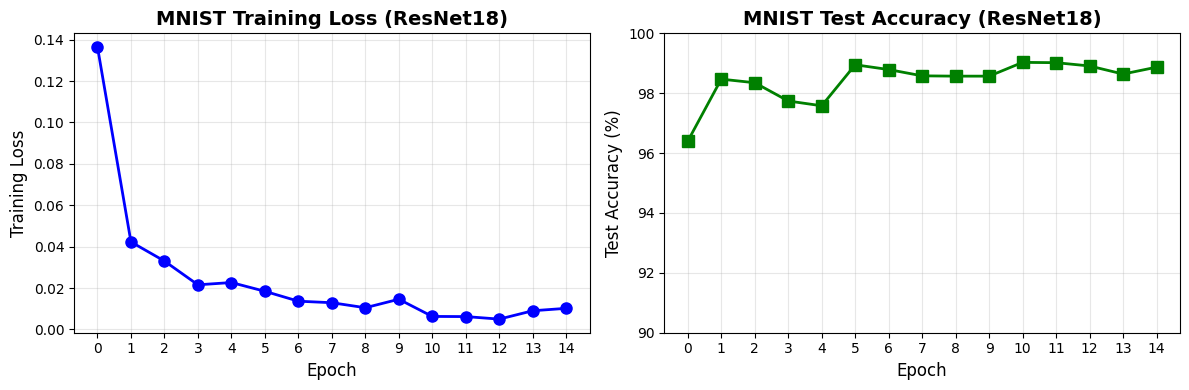

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Setup
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 512
EPOCHS = 15
LR = 0.001

# Prepare MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Download ResNet18 (not pretrained)
print("Downloading ResNet18 model...")
resnet18 = models.resnet18(pretrained=False)

# Modify first layer to accept 1-channel input (MNIST is grayscale)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify output layer for 10 classes (MNIST)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

model = resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting MNIST Training with ResNet18...")
train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
        if batch_idx % 150 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")
    
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print("\nTraining Complete!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Save results with unique names
train_losses_baseline = train_losses.copy()
test_accuracies_baseline = test_accuracies.copy()

# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
epochs_range = range(EPOCHS)
ax1.plot(epochs_range, train_losses, marker='o', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('MNIST Training Loss (ResNet18)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs_range)

# Plot test accuracy
ax2.plot(epochs_range, test_accuracies, marker='s', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
ax2.set_title('MNIST Test Accuracy (ResNet18)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs_range)
ax2.set_ylim([90, 100])

plt.tight_layout()

plt.savefig('resnet18_mnist_training_plots.png', dpi=150, bbox_inches='tight')

print("Training plots saved as 'resnet18_mnist_training_plots.png'")

plt.show()

Using device: cuda:1
Loading MNIST dataset...
Train samples: 60000, Test samples: 10000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting MNIST Training...
Epoch 0, Batch 0/118: Loss=2.4645
Epoch 0, Batch 50/118: Loss=0.1215
Epoch 0, Batch 100/118: Loss=0.0953
Epoch 0 | Train Loss: 0.1368 | Test Accuracy: 98.04%
Epoch 1, Batch 0/118: Loss=0.0398
Epoch 1, Batch 50/118: Loss=0.0374
Epoch 1, Batch 100/118: Loss=0.0385
Epoch 1 | Train Loss: 0.0451 | Test Accuracy: 98.18%
Epoch 2, Batch 0/118: Loss=0.0298
Epoch 2, Batch 50/118: Loss=0.0427
Epoch 2, Batch 100/118: Loss=0.0069
Epoch 2 | Train Loss: 0.0313 | Test Accuracy: 98.62%
Epoch 3, Batch 0/118: Loss=0.0222
Epoch 3, Batch 50/118: Loss=0.0458
Epoch 3, Batch 100/118: Loss=0.0339
Epoch 3 | Train Loss: 0.0274 | Test Accuracy: 99.07%
Epoch 4, Batch 0/118: Loss=0.0236
Epoch 4, Batch 50/118: Loss=0.0361
Epoch 4, Batch 100/118: Loss=0.0085
Epoch 4 | Train Loss: 0.0218 | Test Accuracy: 98.66%
Epoch 5, Batch 0/118: Loss=0.0220
Epoch 5, Batch 50/118: Loss=0.0264
Epoch 5, Batch 100/118: Loss=0.0152
Epoch 5 | Train Loss: 0.0183 | Test Accuracy: 98.68%
Epoch 6, Batch 0/118: Los

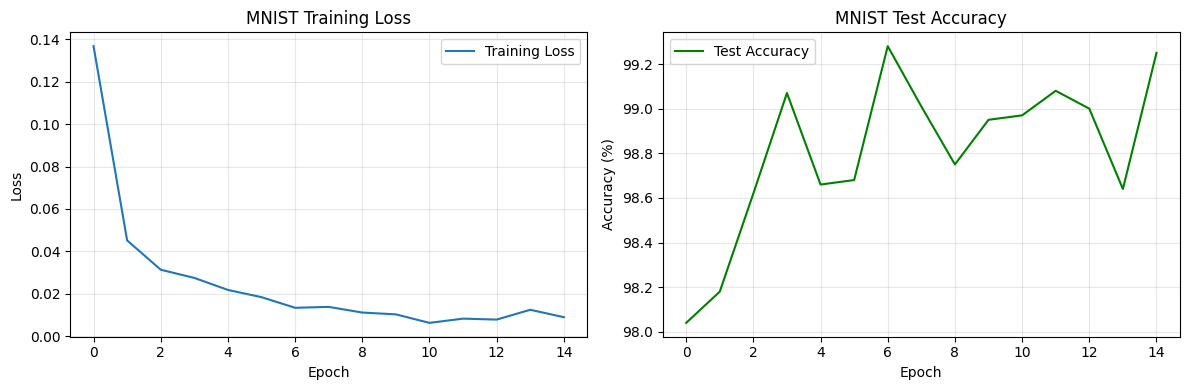

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Dataset parameters
NUM_CLASSES = 10  # MNIST has 10 digit classes
BATCH_SIZE = 512
EPOCHS = 15
LR = 0.001

K_PROBES = 28
EPSILON = 0.1
LAMBDA_JET = 0.1      # Weight for alignment in Jet Loss
ETA_JET = 0.5         # Weight of Jet Loss in total loss [cite: 82]

# Device setup for CUDA
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class MNISTClassifier(nn.Module):
    def __init__(self, num_classes, k_probes, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.k_probes = k_probes
        self.num_classes = num_classes

        v = torch.randn(k_probes, 28*28)  # [k_probes, 784]
        v = v / torch.norm(v, dim=1, keepdim=True)
        self.register_buffer('probes', v)

        # ResNet18 backbone (modified for grayscale MNIST)
        resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        
        # Modify first conv layer for single channel input
        resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model_upper = nn.Sequential(
            resnet_model.conv1,
            resnet_model.bn1,
            resnet_model.relu,
            resnet_model.maxpool,
            resnet_model.layer1,
            resnet_model.layer2,
        )

        self.scalar_projection = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=1, bias=True)
        )

        self.model_lower = nn.Sequential(
            nn.Conv2d(128 + 3, 128, kernel_size=1, padding=0, bias=True),  # 128 from ResNet + O0, O1, O2
            resnet_model.layer3,
            resnet_model.layer4,
            resnet_model.avgpool,
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        # Compute energy as mean of representation
        h = self.model_upper(x)
        energy = self.scalar_projection(h)

        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]

        # grads shape: [batch, 1, 28, 28], probes shape: [k_probes, 28, 28]
        # Flatten spatial dimensions for dot product
        grads_flat = grads.view(grads.size(0), -1)  # [batch, 784]
        probes_flat = self.probes.view(self.k_probes, -1)  # [k_probes, 784]
        
        scores = -torch.matmul(grads_flat, probes_flat.T)  # [batch, k_probes]
        return scores

    def compute_local_fisher(self, x):
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            # Compute derivatives with respect to input
            O0 = self.compute_local_fisher(x)

            # For image tensors, use small Gaussian perturbations instead of probe directions
            mean_v = self.probes.mean(dim=0, keepdim=True).view(1, 1, 28, 28)  # [1, 1, 28, 28]
            x_pos = x + mean_v
            x_neg = x - mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # Forward through ResNet
        h = self.model_upper(x)  # h shape: [batch, 128, 4, 4]
        
        # Reshape O0, O1, O2 to [batch, 1, 1, 1] and broadcast to [batch, 1, 4, 4]
        O0_broadcast = O0.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))  # [batch, 1, 4, 4]
        O1_broadcast = O1.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))  # [batch, 1, 4, 4]
        O2_broadcast = O2.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))  # [batch, 1, 4, 4]
        
        # Concatenate all features
        features = torch.cat([h, O0_broadcast, O1_broadcast, O2_broadcast], dim=1)  # [batch, 131, 4, 4]

        y_hat = self.model_lower(features)
        
        return y_hat, O0 # Return O0 for viz/loss if needed



# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


# Create model
model = MNISTClassifier(NUM_CLASSES, K_PROBES, EPSILON)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

print("Starting MNIST Training...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, energy_score = model(data)
        loss = criterion(output, target)
        mean_v = model.probes.mean(dim=0, keepdim=True)

        # (Uncomment below to enable Jet Loss - adds compute time)
        # x_pos = data + EPSILON * mean_v
        # x_neg = data - EPSILON * mean_v
        # pred_pos, _ = model(x_pos)
        # pred_neg, _ = model(x_neg)
        # D_hat = (pred_pos - pred_neg) / (2 * EPSILON) # [cite: 75]
        # score_proj = -torch.matmul(model.compute_score(data), mean_v.T) # -grad E . v
        # loss_jet = ((D_hat + LAMBDA_JET * score_proj)**2).mean() #
        # loss += ETA_JET * loss_jet


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, energy_score = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MNIST Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('MNIST Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnist_training.png', dpi=150, bbox_inches='tight')
print("Training plots saved as 'mnist_training.png'")
plt.show()

# Save results with unique names

train_losses_no_jet = train_losses.copy()

test_accuracies_no_jet = test_accuracies.copy()

Using device: cuda:1
Loading MNIST dataset...
Train samples: 60000, Test samples: 10000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting MNIST Training...
Epoch 0, Batch 0/118: Loss=2.4649
Epoch 0, Batch 50/118: Loss=0.1209
Epoch 0, Batch 100/118: Loss=0.1110
Epoch 0 | Train Loss: 0.1389 | Test Accuracy: 98.36%
Epoch 1, Batch 0/118: Loss=0.0436
Epoch 1, Batch 50/118: Loss=0.0371
Epoch 1, Batch 100/118: Loss=0.0327
Epoch 1 | Train Loss: 0.0441 | Test Accuracy: 98.15%
Epoch 2, Batch 0/118: Loss=0.0266
Epoch 2, Batch 50/118: Loss=0.0352
Epoch 2, Batch 100/118: Loss=0.0094
Epoch 2 | Train Loss: 0.0316 | Test Accuracy: 98.60%
Epoch 3, Batch 0/118: Loss=0.0186
Epoch 3, Batch 50/118: Loss=0.0331
Epoch 3, Batch 100/118: Loss=0.0255
Epoch 3 | Train Loss: 0.0235 | Test Accuracy: 98.52%
Epoch 4, Batch 0/118: Loss=0.0172
Epoch 4, Batch 50/118: Loss=0.0502
Epoch 4, Batch 100/118: Loss=0.0157
Epoch 4 | Train Loss: 0.0223 | Test Accuracy: 99.05%
Epoch 5, Batch 0/118: Loss=0.0128
Epoch 5, Batch 50/118: Loss=0.0093
Epoch 5, Batch 100/118: Loss=0.0123
Epoch 5 | Train Loss: 0.0176 | Test Accuracy: 99.07%
Epoch 6, Batch 0/118: Los

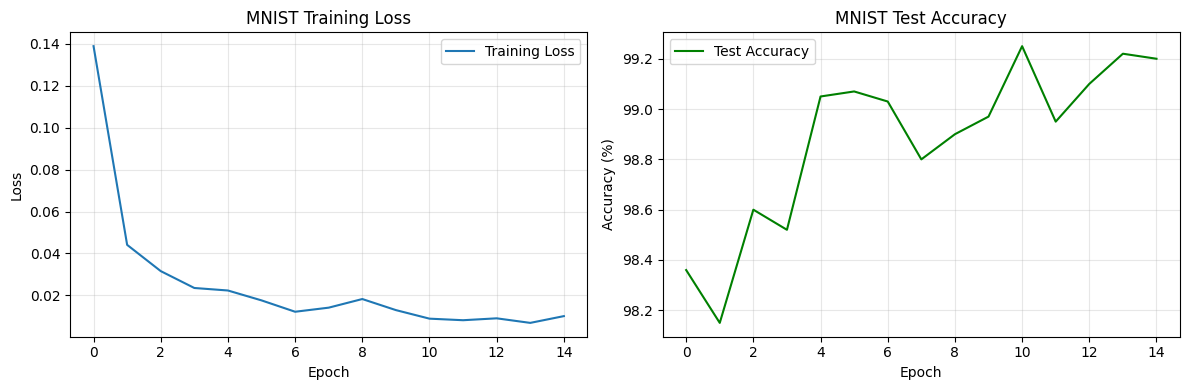

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Dataset parameters
NUM_CLASSES = 10  # MNIST has 10 digit classes
BATCH_SIZE = 512
EPOCHS = 15
LR = 0.001

K_PROBES = 28
EPSILON = 0.1
LAMBDA_JET = 0.1      # Weight for alignment in Jet Loss
ETA_JET = 0.5         # Weight of Jet Loss in total loss [cite: 82]

# Device setup for CUDA
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class MNISTClassifier(nn.Module):
    def __init__(self, num_classes, k_probes, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.k_probes = k_probes
        self.num_classes = num_classes

        v = torch.randn(k_probes, 28*28)  # [k_probes, 784]
        v = v / torch.norm(v, dim=1, keepdim=True)
        self.register_buffer('probes', v)

        # ResNet18 backbone (modified for grayscale MNIST)
        resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        
        # Modify first conv layer for single channel input
        resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model_upper = nn.Sequential(
            resnet_model.conv1,
            resnet_model.bn1,
            resnet_model.relu,
            resnet_model.maxpool,
            resnet_model.layer1,
            resnet_model.layer2,
        )

        self.scalar_projection = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=1, bias=True)
        )

        self.model_lower = nn.Sequential(
            nn.Conv2d(128 + 3, 128, kernel_size=1, padding=0, bias=True),  # 128 from ResNet + O0, O1, O2
            resnet_model.layer3,
            resnet_model.layer4,
            resnet_model.avgpool,
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        # Compute energy as mean of representation
        h = self.model_upper(x)
        energy = self.scalar_projection(h)

        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]

        # grads shape: [batch, 1, 28, 28], probes shape: [k_probes, 28, 28]
        # Flatten spatial dimensions for dot product
        grads_flat = grads.view(grads.size(0), -1)  # [batch, 784]
        probes_flat = self.probes.view(self.k_probes, -1)  # [k_probes, 784]
        
        scores = -torch.matmul(grads_flat, probes_flat.T)  # [batch, k_probes]
        return scores

    def compute_local_fisher(self, x):
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            # Compute derivatives with respect to input
            O0 = self.compute_local_fisher(x)

            # For image tensors, use small Gaussian perturbations instead of probe directions
            mean_v = self.probes.mean(dim=0, keepdim=True).view(1, 1, 28, 28)  # [1, 1, 28, 28]
            x_pos = x + mean_v
            x_neg = x - mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # Forward through ResNet
        h = self.model_upper(x)  # h shape: [batch, 128, 4, 4]
        
        # Reshape O0, O1, O2 to [batch, 1, 1, 1] and broadcast to [batch, 1, 4, 4]
        O0_broadcast = O0.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))  # [batch, 1, 4, 4]
        O1_broadcast = O1.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))  # [batch, 1, 4, 4]
        O2_broadcast = O2.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))  # [batch, 1, 4, 4]
        
        # Concatenate all features
        features = torch.cat([h, O0_broadcast, O1_broadcast, O2_broadcast], dim=1)  # [batch, 131, 4, 4]

        y_hat = self.model_lower(features)
        
        return y_hat, O0 # Return O0 for viz/loss if needed



# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


# Create model
model = MNISTClassifier(NUM_CLASSES, K_PROBES, EPSILON)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

print("Starting MNIST Training...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, energy_score = model(data)
        loss = criterion(output, target)
        mean_v = model.probes.mean(dim=0, keepdim=True).view(1, 1, 28, 28)

        # (Uncomment below to enable Jet Loss - adds compute time)
        x_pos = data + EPSILON * mean_v
        x_neg = data - EPSILON * mean_v
        pred_pos, _ = model(x_pos)
        pred_neg, _ = model(x_neg)
        D_hat = (pred_pos - pred_neg) / (2 * EPSILON) # [cite: 75]
        score_proj = model.compute_score(data).mean(dim=1, keepdim=True)  # [batch, 1]
        loss_jet = ((D_hat + LAMBDA_JET * score_proj)**2).mean() #
        loss += ETA_JET * loss_jet


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, energy_score = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MNIST Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('MNIST Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnist_training_Jet_Loss.png', dpi=150, bbox_inches='tight')
print("Training plots saved as 'mnist_training_Jet_Loss.png'")
plt.show()

# Save results with unique names

train_losses_jet = train_losses.copy()

test_accuracies_jet = test_accuracies.copy()

Results saved to training_results_comparison.csv

DataFrame Preview:
    Epoch  Baseline_Train_Loss  Baseline_Test_Accuracy  No_Jet_Train_Loss  \
0       0             0.136505                   96.40           0.136792   
1       1             0.042298                   98.47           0.045130   
2       2             0.033047                   98.35           0.031294   
3       3             0.021565                   97.74           0.027432   
4       4             0.022672                   97.58           0.021759   
5       5             0.018435                   98.95           0.018340   
6       6             0.013654                   98.79           0.013328   
7       7             0.012916                   98.58           0.013753   
8       8             0.010491                   98.57           0.011083   
9       9             0.014600                   98.57           0.010227   
10     10             0.006289                   99.03           0.006205   
11     

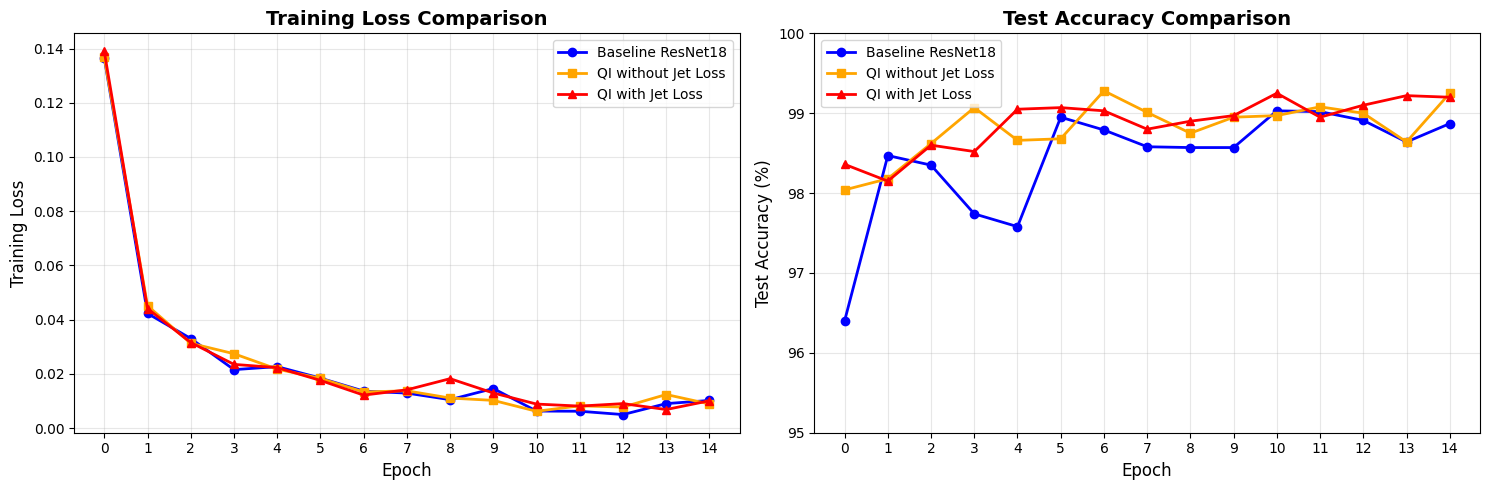


Final Test Accuracy Summary:
Baseline ResNet18:       98.87%
QI without Jet Loss:     99.25%
QI with Jet Loss:        99.20%


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame with all results
epochs = list(range(15))
results_df = pd.DataFrame({
    'Epoch': epochs,
    'Baseline_Train_Loss': train_losses_baseline,
    'Baseline_Test_Accuracy': test_accuracies_baseline,
    'No_Jet_Train_Loss': train_losses_no_jet,
    'No_Jet_Test_Accuracy': test_accuracies_no_jet,
    'Jet_Train_Loss': train_losses_jet,
    'Jet_Test_Accuracy': test_accuracies_jet
})

# Save to CSV
csv_filename = 'training_results_comparison.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")
print("\nDataFrame Preview:")
print(results_df)

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss Comparison
ax1.plot(epochs, train_losses_baseline, marker='o', linewidth=2, markersize=6, label='Baseline ResNet18', color='blue')
ax1.plot(epochs, train_losses_no_jet, marker='s', linewidth=2, markersize=6, label='QI without Jet Loss', color='orange')
ax1.plot(epochs, train_losses_jet, marker='^', linewidth=2, markersize=6, label='QI with Jet Loss', color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs)

# Plot 2: Test Accuracy Comparison
ax2.plot(epochs, test_accuracies_baseline, marker='o', linewidth=2, markersize=6, label='Baseline ResNet18', color='blue')
ax2.plot(epochs, test_accuracies_no_jet, marker='s', linewidth=2, markersize=6, label='QI without Jet Loss', color='orange')
ax2.plot(epochs, test_accuracies_jet, marker='^', linewidth=2, markersize=6, label='QI with Jet Loss', color='red')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
ax2.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs)
ax2.set_ylim([95, 100])

plt.tight_layout()
plt.savefig('training_results_comparison.png', dpi=150, bbox_inches='tight')
print(f"\nComparison plot saved as 'training_results_comparison.png'")
plt.show()

# Print final accuracies
print("\n" + "="*60)
print("Final Test Accuracy Summary:")
print("="*60)
print(f"Baseline ResNet18:       {test_accuracies_baseline[-1]:.2f}%")
print(f"QI without Jet Loss:     {test_accuracies_no_jet[-1]:.2f}%")
print(f"QI with Jet Loss:        {test_accuracies_jet[-1]:.2f}%")
print("="*60)